# Modeling Drug Dynamics using Programmatic PK/PD Models in Python 
## An Introduction to PK/PD Modeling using PySB and pysb-pkpd

tags: [Python, pharmacology, PK/PD, QSP, PySB]

![image](https://drive.google.com/uc?id=1H1E_hIdDgICcKBXAjTWj77r2-AB7QCdp)

Over the past few months, I've been spending time here and there learning some of the basics of Pharmacokinetic (PK) and Pharmacodynamic (PD) modeling and how they are used together in PK/PD models to understand drug pharmacology. I've also been developing a PK/PD-focused add-on for the [PySB](https://pysb.org/) modeling framework, [pysb-pkpd](https://github.com/blakeaw/pysb-pkpd), which I believe to be a great option for programmatically constructing and executing various types of compartmental PK/PD models in Python. Particularly, since there don't seem to be many free and open-source tools for PK/PD modeling in Python. With this post, I wanted to compile and share some of what I've learned while also providing a practical resource for others potentially interested in programmatic PK/PD modeling in Python using [PySB](https://pysb.org/) and [pysb-pkpd](https://github.com/blakeaw/pysb-pkpd). 

So, in this post, we'll start with the basics of PK/PD modeling and a quick overview of the PySB framework. Then we'll dive into creating dynamic PK/PD models of drug behavior and response using PySB and pysb-pkpd, featuring two illustrative case studies.

______

## Contents

1. What is PK/PD modeling?
    1. Types of PK/PD Models
    2. Additional PK terms
    3. PD Functions
2. Setting Up Your Python Environment
3. A Quick Intro to PySB Models
    1. Compartmental PySB Models
5. PK/PD modeling with PySB and pysb-pkpd
    1. What is pysb-pkpd?
    2. Case Study 1: Building a two-compartment model
        1. Standard PySB
        2. PySB plus pysb-pkpd
        3. Comparison
        4. Simulate the models
    3. Case Study 2: Pembrolizumab semi-mechanistic PKRO model
        1. Constructing the Model
        2. Simulate the Model
        3. Visualize Results
6. Concluding Thoughts
7. Acknowledgements
8. References

______

## What is PK/PD modeling?

Before getting into the specifics of using [PySB](https://pysb.org/) and [pysb-pkpd](https://github.com/blakeaw/pysb-pkpd), we'll briefly review some basic PK/PD modeling concepts. 

PK/PD models are mathematical models used to study the intricate relationships between pharmacokinetics and pharmacodynamics[<sup>1-3</sup>](#references), two essential branches of pharmacology that study what drugs do in and to the body. **Pharmacokinetics (PK)** describes the processes that affect drug concentration in the body[<sup>1,3,4</sup>](#references), including key processes related to how a drug enters the body or the circulatory system (i.e., absorption), how it moves through the body and partitions amongst the different tissues or organs (i.e., distribution), how the body chemically alters or breaks down the drug (i.e., metabolism), and how the drug or it's metabolites exit the body (i.e., excretion). You'll often see the acronym **ADME** used as an abbreviation for the processes of absorption, distribution, metabolism, and excretion,[<sup>4,5</sup>](#references); other similar acronyms may emphasize other important factors too (e.g., _ABCD_ or _ADMET_)[<sup>5</sup>](#references) **Pharmacodynamics (PD)** characterizes the relationship between drug concentration (or dose) and the resulting pharmacological effect<sup>1,3</sup>. Another way to think about it is that PK processes describe what the _body does to a drug_ after it is administered[<sup>1,6</sup>](#references), while PD describes what a _drug does to the body_. Importantly, PK/PD modeling integrates PK and PD to describe how the pharmacological effect of a drug changes over time[<sup>1-3</sup>](#references). 

In short, for a given drug dose[<sup>1</sup>](#references):
  * PK = concentration vs. time
  * PD = effect vs. concentration
  * PK/PD = effect vs. time

### Types of PK/PD Models

There are various approaches to PK/PD modeling that can be employed depending on the type of data available, how well we understand the biological mechanisms of a drug, as well as other aspects of a drug's behavior and response. Here, we'll touch on three categories of PK/PD models that can be implemented using PySB and pysb-pkpd: compartmental models[<sup>4,7-9</sup>](#references), mechanistic/semi-mechanistic models[<sup>10,11</sup>](#references), and quantitative systems pharmacology/toxicology models[<sup>12-14</sup>](#references).

#### Compartmental PK/PD Models

Compartmental models partition the body into distinct hypothetical compartments[<sup>4,7-9</sup>](#references), each potentially representing a biological system in the body like the circulatory system, tissues, or organs. A drug moves between, or _distributes_ across, the compartments, approximating distribution in the body. These models may also include drug absorption and typically include drugs exiting the body through clearance or elimination (see: Additional PK terms). The number of compartments encodes the granularity level with which the drug distribution is modeled. Common compartmental models include:

  * **One-Compartment Model**: Treats the body as a single compartment, a reasonable approximation for drugs that distribute quickly and uniformly throughout the body[<sup>4,7,9,15</sup>](#references). 

  * **Two-Compartment Model**: Breaks the body into a Central and a Peripheral compartment[<sup>4,7,9,15</sup>](#references). The Central compartment typically represents the circulatory system and well-perfused tissues, while the Peripheral compartment represents other tissues and organs that aren't well-perfused. This model is useful when there is a delay in the drug distribution from the circulatory system to other tissues. 

  * **Three-Compartment Model**: Builds on the two-compartment model by adding a second peripheral compartment[<sup>4,9</sup>](#references). This third compartment (e.g., Deep Peripheral, Deep Tissue, or Slow Peripheral), typically represents tissues with slower distribution kinetics, which is beneficial when a drug has multiple distribution phases because it distributes at different rates to different tissues.  

In one-, two-, and three-compartment models, the compartments are really just theoretical constructs that facilitate empirical estimation of key PK parameters through fitting to clinical or other experimental data rather than a true representation of the body[<sup>4</sup>](#references). A drug's plasma concentration-time profile can suggest which model may be most appropriate[<sup>9,15</sup>](#references). In some cases, two- and three-compartment models may also be extended to have a separate _Effect_ compartment that can be used to capture an indirect link between drug concentration and effects[<sup>1,8</sup>](#references). 

More complex distribution scenarios between tissues and organs can be captured by increasing the number of compartments, as seen in physiologically-based PK (PBPK) models[<sup>16,17</sup>](#references). 

    
#### Mechanistic/Semi-Mechanistic Models

Mechanistic and semi-mechanistic models build on compartmental PK/PD models by incorporating more details of the drug's mechanism of action and the underlying biology that can help connect drug behavior with important biomarkers[<sup>10,11</sup>](#references). They can also be used to link effects with the dynamics of complex processes that can't be easily measured in experiments. For example, in classical [receptor theory](https://en.wikipedia.org/wiki/Receptor_theory), there is a pharmacodynamic relationship between the observed effect and receptor occupancy (RO). A semi-mechanistic model could incorporate additional mechanisms related to drug binding at the target receptor and the receptor's activation or inhibition, as well as processes like receptor turnover or other downstream products of receptor targeting. 

#### Quantitative Systems Pharmacology/Toxicology Models

Quantitative systems pharmacology (QSP) models further build on mechanistic/semi-mechanistic PK/PD modeling with concepts from systems biology[<sup>12,13</sup>](#references). In QSP models, drug effects can be considered to arise out of complex networks of interactions that form a biological system and may incorporate additional details of biochemical signaling pathways, disease processes, and a drug's mechanism of action. Quantitative systems toxicology (QST) models similarly incorporate ideas of systems biology but focus on understanding and quantifying drug side effects as opposed to primary drug pharmacology[<sup>13,14</sup>](#references).       

### Additional PK terms

Here are a few more important terms used in PK modeling and analysis:

  * **Dose**/**Dosage**: _Dose_ is how much drug is administered at a particular time[<sup>18</sup>](#references), while _Dosage_ refers to multiple doses taken over a period of time with a given frequency. Note that the administration route (e.g., oral vs. I.V.) along with the dose and/or dosage are critical considerations for any particular dosing strategy[<sup>19</sup>](#references).
  * **Bioavailability ($\beta$)**: the fraction of a drug dose that gets absorbed and can reach the site of action[<sup>5,20</sup>](#references). Often associated with administering a drug via an oral route where not all of the drug will enter circulation before being metabolized or excreted.
  * **Volume of distribution ($V_d$)**: the theoretical volume into which an administered drug would be distributed to yield a measured plasma concentration[<sup>15,21,22</sup>](#references): $concentration = dose / V_d$. It can provide insight into a drug's tendency to stay in the plasma or disperse into tissues and organs. Importantly, $V_d$ may be not a fixed value. It can also be linked to compartment volumes in compartmental modeling. For instance, in a one-compartment model, $V_d$ equals the central compartment volume[<sup>15</sup>](#references). However, in multicompartment models, the relationship is more complicated. 
  * **Elimination**: removal of the drug from the body by processes like metabolism and excretion[<sup>23,24</sup>](#references). In PK models it is often modeled as a linear process with first-order reaction kinetics: i.e., _linear elimination_.
  * **Clearance (CL)**: removal of drug from the plasma measured as the volume of plasma 'cleared' (i.e., free of drug) per unit time[<sup>15,24,25</sup>](#references). Or, alternatively, as the rate of drug _elimination_ (amount/time) divided by the drug's plasma concentration (amount/volume). With a compartmental model and assuming linear elimination, an associated first-order rate constant for the corresponding elimination process can be expressed as $k = CL / V_i $ with clearance $CL$ from a compartment with volume $V_i$. 

### PD functions

The **Emax** class of functions is a common choice of PD functions when modeling a _direct effect_ (or _direct link_) in a PK/PD model[<sup>1,8,26</sup>](#references). These functions relate drug concentration (or dose) to effect using a non-linear sigmoid function, which is also common in biochemistry ([Hill or Hill-Langmuir equations](https://en.wikipedia.org/wiki/Hill_equation_(biochemistry))) and classic receptor theory (e.g., Clark equation): 

  * **Emax** - $E = E_{max} \left[Drug\right] / (\left[Drug\right] + EC_{50})$, where $E_{max}$ is termed the maximum effect and $EC_{50}$ is the concentration at which effect is at half-maximum[<sup>1,26</sup>](#references). If considering a baseline effect $E_0$, it can be expanded to $E = E_0 \pm E_{max} \left[Drug\right] / (\left[Drug\right] + EC_{50})$.
  * **Sigmoidal Emax** (or Sigmoid Emax) - the more generic form of the Emax function[<sup>1,26</sup>](#references): $E = E_{max} \left[Drug\right]^n / (\left[Drug\right]^n + EC_{50}^n)$, where $n$ the Hill slope and determines how the steepness of the sigmoid function jump. If considering a baseline effect $E_0$, it can be expanded to $E = E_0 \pm E_{max} \left[Drug\right]^n / (\left[Drug\right]^n + EC_{50}^n)$. Note that the first **Emax** function is a special case of this one in which $n=1$. 

Some other possible PD functions include:
    
  * **Linear Effect Model** - the effect is just a linear function of drug concentration[<sup>1</sup>](#references): $E = m \left[ Drug \right]$ with slope $m$ or $E = m \left[ Drug \right] + E_0$ if considering a baseline effect $E_0$.
  * **Log-linear Effect Model** - the effect varies linearly with the logarithm of the concentration[<sup>1</sup>](#references): $E = m \log \left[ Drug \right] + b$ with slope $m$ and intercept $b$.
  * **Fixed-Effect Model** - the effect has a fixed magnitude that only occurs after reaching some threshold concentration[<sup>1</sup>](#references): $E = E_{fixed}, \,\, \left[ Drug \right] > \left[ Drug \right]_{threshold}$ and zero otherwise.


**Note**: In cases where there's a delay between drug concentration and its effect (_indirect link_; e.g., when peak concentration and peak effect don't align), it's possible to use a separate _Effect_ compartment in conjunction with a direct effect PD function to model this scenario[<sup>1,8</sup>](#references).  

______

## Setting Up Your Python Environment



I recommend using a `conda` environment so you can more easily install PySB while managing other dependencies. These days, I prefer to use [miniconda](https://docs.conda.io/projects/miniconda/en/latest/) and then just install what I need in new environments. If you don't want to use `conda` you should still be able to follow along with some adjustments to the following steps. 

The main packages we need are [PySB](https://pysb.org/) and [pysb-pkpd](https://github.com/blakeaw/pysb-pkpd):

**PySB**
```
conda install -c alubbock pysb
```
Other options for installation are available at the [PySB Download Page](https://pysb.org/download.html)

**pysb-pkpd** - (currently version 0.2.1)
```
pip install git+https://github.com/blakeaw/pysb-pkpd@v0.2.1
```


I also recommend going ahead and installing [Cython](https://cython.org/). It is used by PySB to compile ODEs and improve the speed of the `ScipyOdeSimulator`, which we will be using here:

```
conda install cython
```

To make the plots demonstrated here be sure you have [matplotlib](https://matplotlib.org/):
```
conda install matplotlib seaborn
```
If you prefer some other plotting library you can swap out the plotting commands as needed. 

Lastly, for a more interactive and dynamic experience, I'd recommend following along and executing the examples in your own computational notebook. I like [JupyterLab](https://jupyter.org/):
```
pip install jupyterlab
```
However, you could also try something like [Google Colab](https://colab.google/) (although dependencies may be a little trickier).

______

## A Quick Intro to PySB Models

[PySB](https://pysb.org/) is a Python-based framework for systems biology modeling that allows users to programmatically encode and simulate mathematical models of complex biological systems using ordinary differential equations, stochastic differential equations, and network-free modeling approaches. PySB was originally developed for reaction modeling of intricate biochemical systems[<sup>27</sup>](#references), such as cell signaling pathways, adopting a rule-based approach that builds on the rule-based modeling platforms [BioNetGen](https://bionetgen.org/) and [Kappa](https://kappalanguage.org/). In rule-based modeling, a model is encoded using a simplified set of pattern-based _rules_ that describe biochemical actions (e.g., _Protein A binds Protein B_) rather than an explicit enumeration of all the reactions and molecular/complex species[<sup>27,28</sup>](#references). When using differential equation methods, the model rules are converted into a complex reaction network from which all the differential equations are then generated. This eliminates the need for the modeler to explicitly define all the differential equations of the model. 

What sets PySB apart though is its Pythonic approach in which model components are Python class-based objects[<sup>27</sup>](#references), allowing models to be expressed as Python programs rather than separate domain-specific language files. This design choice enables seamless integration, manipulation, and execution of PySB models within Python workflows. Furthermore, it promotes modularity and reusability by facilitating the encapsulation of recurring biochemical actions into reusable _macros_[<sup>27</sup>](#references). 

If you are new to PySB, I recommend starting with the PySB tutorial available at https://pysb.org/tutorials/ and then the more in-depth tutorial at https://pysb.readthedocs.io/en/stable/tutorial.html. These are excellent resources for beginners to learn the fundamentals of building and executing PySB models. You can also check out various example PySB models at https://github.com/pysb/pysb/tree/master/pysb/examples.

### Compartmental PySB models

Although mentioned in the in-depth PySB tutorial, compartments and their use in PySB models aren't thoroughly discussed or shown in the example models so we'll briefly touch on this here.

A compartment is defined in a model with the `Compartment` class and is included in monomer patterns with the `**` operator. 

Let's build a simple compartmental model with reversible transfer between two compartments:

![image](https://drive.google.com/uc?id=1PmBUAcBnOFA6rUk-2IfajVJGI69Y09av)

First, we'll import from `pysb`:

In [1]:
from pysb import *

Next, we can initialize the model:

In [2]:
# 1. Initialize a new PySB model:
Model(name='compartmental')
# The model will be assigned to a local variable named compartmental.

<Model 'compartmental' (monomers: 0, rules: 0, parameters: 0, expressions: 0, compartments: 0, energypatterns: 0) at 0x23fade15c50>

Now, let's add the first compartment:

In [3]:
# 2. Add the two compartments:
Compartment('COMP_1')

Compartment(name='COMP_1', parent=None, dimension=3, size=None)

And, the second compartment:

In [4]:
Compartment('COMP_2')

Compartment(name='COMP_2', parent=None, dimension=3, size=None)

Now, define the monomer for our model protein:

In [5]:
# 3. Add a "protein" and initialize it in the
# first compartment:
Monomer('protein')

Monomer('protein')

And, then define a parameter for the initial concentration of protein:

In [6]:
Parameter('protein_0', 100.)

Parameter('protein_0', 100.0)

Next, we can define the initial concentration of the protein in `COMP_1`:

In [7]:
Initial(protein()**COMP_1, protein_0)

Initial(protein() ** COMP_1, protein_0)

Here, we'll create the rule for reversible distribution of protein between the two compartments. First, we can create a new parameter for the 1st order rate constant for transfer from `COMP_1` to `COMP_1`:

In [8]:
# 4. New rule and associated parameters for reversible distribution between the two
# compartments:
Parameter('k_12', 1e-2)

Parameter('k_12', 0.01)

Second, we can create the parameter for the 1st order rate constant for the reverse transfer, `COMP_2` to `COMP_1`:

In [9]:
Parameter('k_21', 2e-3)

Parameter('k_21', 0.002)

Finally, we'll define the associated reversible rule for the distribution between the compartments:

In [10]:
Rule('C1_to_C2', protein()**COMP_1 | protein()**COMP_2, k_12, k_21)

Rule('C1_to_C2', protein() ** COMP_1 | protein() ** COMP_2, k_12, k_21)

Then, we can have it print out some model details:

In [11]:
print(compartmental)

<Model 'compartmental' (monomers: 1, rules: 1, parameters: 3, expressions: 0, compartments: 2, energypatterns: 0) at 0x23fade15c50>


In short, the model code would look like:

```python
from pysb import *

Model(name='compartmental')
Compartment('COMP_1')
Compartment('COMP_2')
Monomer('protein')
Parameter('protein_0', 100.)
Initial(protein()**COMP_1, protein_0)
Parameter('k_12', 1e-2)
Parameter('k_21', 2e-3)
Rule('C1_to_C2', protein()**COMP_1 | protein()**COMP_2, k_12, k_21)
```


#### Another compartmental model example

For another, more realistic, example of a compartmental PySB model, you can explore the following model: PARM - https://github.com/NTBEL/PARM 
______

## PK/PD modeling with PySB and pysb-pkpd

### What is pysb-pkpd?
[pysb-pkpd](https://github.com/blakeaw/pysb-pkpd) is a PySB add-on that introduces the language of pharmacokinetics and pharmacodynamics to PySB models. It achieves this by encoding PK actions, PD functions, and drug dosing into specialized PySB macros, simplifying the creation of compartmental PK/PD models. Moreover, PySB provides a natural foundation for expanding these models into mechanistic PK/PD models and more complex quantitative systems pharmacology/toxicology (QSP/QST) models.

### Case Study 1: Building a two-compartment model

In this first case study, we will construct two different versions of a two-compartment PK model with an Emax PD function. We will build the first version exclusively using the standard PySB framework, and in the second we will use PySB with the pysb-pkpd add-on. This case study will provide a practical, side-by-side comparison, highlighting the added efficiency and pharmacological context that pysb-pkpd brings to PySB-based PK/PD model construction. 

Here is a schematic of the model we will construct:

![image](https://drive.google.com/uc?id=1E_pNLou2el53r14_YplCKwtcUlSJVjNd)

#### 1. Standard PySB

First, we'll build this model using standard PySB objects and macros.

Initialize the new model:

In [12]:
Model(name='standard')

C:\Users\bwils\AppData\Local\Temp\ipykernel_21400\2387899035.py:1: ModelExistsWarning: Redefining model! (You can probably ignore this if you are running code interactively)
  Model(name='standard')


<Model 'standard' (monomers: 0, rules: 0, parameters: 0, expressions: 0, compartments: 0, energypatterns: 0) at 0x23fb0448810>

Setup the two compartments, a central and peripheral one:

In [13]:
# Volume of the central compartment:
Parameter('V_CENTRAL', 1.0)

Parameter('V_CENTRAL', 1.0)

In [14]:
Compartment('CENTRAL', size=V_CENTRAL)

Compartment(name='CENTRAL', parent=None, dimension=3, size=V_CENTRAL)

In [15]:
# Volume of the peripheral compartment:
Parameter('V_PERIPHERAL', 1.0)

Parameter('V_PERIPHERAL', 1.0)

In [16]:
Compartment('PERIPHERAL', size=V_PERIPHERAL)

Compartment(name='PERIPHERAL', parent=None, dimension=3, size=V_PERIPHERAL)

Add the drug monomer:

In [17]:
Monomer('Drug')

Monomer('Drug')

Initialize the drug in the central compartment to approximate an IV bolus dose:

In [18]:
# The amount of drug added:
Parameter('drug_dose', 100.) # mg

Parameter('drug_dose', 100.0)

In [19]:
# The initial concentration:
Expression('drug_0', drug_dose / V_CENTRAL)

Expression('drug_0', drug_dose/V_CENTRAL)

In [20]:
Initial(Drug()**CENTRAL, drug_0)

Initial(Drug() ** CENTRAL, drug_0)

Now add a rule to include reversible distribution/redistribution between the two compartments:

<div class="alert alert-info">
Here, we can take advantage of an existing PySB macro, <strong>equilibrate</strong>, to encode the reversible distribution/redistribution and the associated parameters.
</div>

In [21]:
from pysb.macros import equilibrate

In [22]:
equilibrate

<function pysb.macros.equilibrate(s1, s2, klist)>

In [23]:
# Distribution/redistribution using the equilibrate macro:
equilibrate(Drug()**CENTRAL, Drug()**PERIPHERAL, [3e-4, 3e-5]) 

ComponentSet([
 Rule('equilibrate_Drug_to_Drug', Drug() ** CENTRAL | Drug() ** PERIPHERAL, equilibrate_Drug_to_Drug_kf, equilibrate_Drug_to_Drug_kr),
 Parameter('equilibrate_Drug_to_Drug_kf', 0.0003),
 Parameter('equilibrate_Drug_to_Drug_kr', 3e-05),
 ])

And let's add removal of the drug from the central compartment by linear elimination:

<div class="alert alert-info">
Here, we can also take advantage of an existing PySB macro, <strong>degrade</strong>, to encode the linear elimination of the drug.
</div>

In [24]:
from pysb.macros import degrade

In [25]:
degrade

<function pysb.macros.degrade(species, kdeg)>

In [26]:
degrade(Drug()**CENTRAL, 1e-5)

ComponentSet([
 Rule('degrade_Drug', Drug() ** CENTRAL >> None, degrade_Drug_k),
 Parameter('degrade_Drug_k', 1e-05),
 ])

Now, let's encode the Emax function for the concentration-response relationship:

In [27]:
# The Emax parameter:
Parameter('Emax', 1.0)

Parameter('Emax', 1.0)

In [28]:
# The EC50:
Parameter('EC50', 50.0)

Parameter('EC50', 50.0)

In [29]:
# Drug in the peripheral compartment:
Observable('drug_peripheral', Drug()**PERIPHERAL)

Observable('drug_peripheral', Drug() ** PERIPHERAL)

In [30]:
Expression('Emax_peripheral', Emax * drug_peripheral / (drug_peripheral + EC50) )

Expression('Emax_peripheral', drug_peripheral*Emax/(drug_peripheral + EC50))

In [31]:
print(standard)

<Model 'standard' (monomers: 1, rules: 2, parameters: 8, expressions: 2, compartments: 2, energypatterns: 0) at 0x23fb0448810>


In short, the model code for this version looks like:

```python
from pysb import *
from pysb.macros import equilibrate, degrade

# Initialize new model:
Model(name='standard')
# Setup the two compartments:
Parameter('V_CENTRAL', 1.0)
Compartment('CENTRAL', size=V_CENTRAL)
Parameter('V_PERIPHERAL', 1.0)
Compartment('PERIPHERAL', size=V_PERIPHERAL)
# New drug monomer and bolus dose:
Monomer('Drug')
Parameter('drug_dose', 100.)
Expression('drug_0', drug_dose / V_CENTRAL)
Initial(Drug()**CENTRAL, drug_0)
# Distribution/redistribution:
equilibrate(Drug()**CENTRAL, Drug()**PERIPHERAL, [3e-4, 3e-5]) 
# Linear elimination:
degrade(Drug()**CENTRAL, 1e-5)
# Emax function for Drug in the peripheral compartment:
Parameter('Emax', 1.0)
Parameter('EC50', 50.0)
Expression('Emax_peripheral', Emax * drug_peripheral / (drug_peripheral + EC50) )
```

#### 2. PySB plus pysb-pkpd

Next, we'll build the same model but using pysb-pkpd.

Here is a the schematic again for reference:

![image](https://drive.google.com/uc?id=1E_pNLou2el53r14_YplCKwtcUlSJVjNd)

Now, let's get started by importing `pysb-pkpd`:

In [32]:
import pysb.pkpd as pkpd

Initialize the new model:

In [33]:
Model(name='pysb_pkpd')

<Model 'pysb_pkpd' (monomers: 0, rules: 0, parameters: 0, expressions: 0, compartments: 0, energypatterns: 0) at 0x23fad0dfc10>

In [34]:
pysb_pkpd

<Model 'pysb_pkpd' (monomers: 0, rules: 0, parameters: 0, expressions: 0, compartments: 0, energypatterns: 0) at 0x23fad0dfc10>

Setup the two compartments, a central and peripheral one:

<div class="alert alert-info">
pysb-pkpd has a macro, <strong>two_compartments</strong>, which creates the necessary compartments for a two-compartment model.
</div>

In [35]:
pkpd.two_compartments

<function pysb.pkpd.macros.two_compartments(c1_name='CENTRAL', c1_size=1.0, c2_name='PERIPHERAL', c2_size=1.0)>

We can use it to add the compartments to new model:

In [36]:
pkpd.two_compartments()

C:\Users\bwils\miniconda3\envs\pysb-pkpd-dev\Lib\site-packages\pysb\pkpd\macros.py:162: SymbolExistsWarning: 'V_CENTRAL' already defined
  C1_size = Parameter("V_{0}".format(c1_name), c1_size)
C:\Users\bwils\miniconda3\envs\pysb-pkpd-dev\Lib\site-packages\pysb\pkpd\macros.py:166: SymbolExistsWarning: 'V_PERIPHERAL' already defined
  C2_size = Parameter("V_{0}".format(c2_name), c2_size)
C:\Users\bwils\miniconda3\envs\pysb-pkpd-dev\Lib\site-packages\pysb\pkpd\macros.py:168: SymbolExistsWarning: 'CENTRAL' already defined
  C1 = Compartment(c1_name, size=C1_size)
C:\Users\bwils\miniconda3\envs\pysb-pkpd-dev\Lib\site-packages\pysb\pkpd\macros.py:169: SymbolExistsWarning: 'PERIPHERAL' already defined
  C2 = Compartment(c2_name, size=C2_size)


ComponentSet([
 Compartment(name='CENTRAL', parent=None, dimension=3, size=V_CENTRAL),
 Compartment(name='PERIPHERAL', parent=None, dimension=3, size=V_PERIPHERAL),
 Parameter('V_CENTRAL', 1.0),
 Parameter('V_PERIPHERAL', 1.0),
 ])

Add the drug monomer:

<div class="alert alert-info">
pysb-pkpd also includes a macro, <strong>drug_monomer</strong> for adding a simple "Drug" monomer to the model that doesn't have any binding sites or states. 
</div>


In [37]:
pkpd.drug_monomer

<function pysb.pkpd.macros.drug_monomer(name='Drug')>

In [38]:
pkpd.drug_monomer()

C:\Users\bwils\miniconda3\envs\pysb-pkpd-dev\Lib\site-packages\pysb\pkpd\macros.py:63: SymbolExistsWarning: 'Drug' already defined
  monomer = Monomer(name)


ComponentSet([
 Monomer('Drug'),
 ])

Initialize the drug in the central compartment to approximate an IV bolus dose:

<div class="alert alert-info">
pysb-pkpd includes macros for adding a dose of a drug to the model. Currently, version 0.2.1 includes three such macros: <strong>dose_bolus</strong>, <strong>dose_infusion</strong>, and <strong>dose_absorbed</strong> for modeling an instantaneous I.V. bolus, continuous I.V. infusion, and oral dosing, respectively. In this case, we want the <strong>dose_bolus</strong> macro.
</div>

In [39]:
pkpd.dose_bolus

<function pysb.pkpd.macros.dose_bolus(species, compartment, dose)>

In [40]:
pkpd.dose_bolus(Drug, CENTRAL, 100.)

ComponentSet([
 Parameter('dose_Drug_CENTRAL', 100.0),
 Expression('expr_Drug_CENTRAL_0', dose_Drug_CENTRAL/V_CENTRAL),
 ])

Now add a rule to include reversible distribution/redistribution between the two compartments:

<div class="alert alert-info">
pysb-pkpd includes several macros that encode PK actions/processes. The <strong>distribute</strong> macro encodes reversible distribution/redistribution between two compartments.
</div>

In [41]:
pkpd.distribute

<function pysb.pkpd.macros.distribute(species, c1, c2, klist)>

In [42]:
# Distribution/redistribution using the distribute macro:
pkpd.distribute(Drug, CENTRAL, PERIPHERAL, [3e-4, 3e-5]) 

ComponentSet([
 Rule('distribute_Drug_CENTRAL_to_PERIPHERAL', Drug() ** CENTRAL | Drug() ** PERIPHERAL, distribute_Drug_CENTRAL_to_PERIPHERAL_kf, distribute_Drug_CENTRAL_to_PERIPHERAL_kr),
 Parameter('distribute_Drug_CENTRAL_to_PERIPHERAL_kf', 0.0003),
 Parameter('distribute_Drug_CENTRAL_to_PERIPHERAL_kr', 3e-05),
 ])

And let's add removal of the drug from the central compartment by linear elimination:

<div class="alert alert-info">
pysb-pkpd includes PK macros for removing drug, including <strong>clearance</strong>, <strong>eliminate</strong>, and <strong>eliminate_mm</strong> macros for linear clearance (with a clearance rate CL and first-order rate constant given by CL/Volume), linear elimination (with first-order rate constant), and non-linear Michaelis-Menten elimination (with Vmax and Km parameters), respectively. In this case, we can use the <strong>eliminate</strong> macro.

In [43]:
pkpd.eliminate

<function pysb.pkpd.macros.eliminate(species, compartment, kel)>

In [44]:
pkpd.eliminate(Drug, CENTRAL, 1e-5)

ComponentSet([
 Rule('eliminate_Drug_CENTRAL', Drug() ** CENTRAL >> None, eliminate_Drug_CENTRAL_k),
 Parameter('eliminate_Drug_CENTRAL_k', 1e-05),
 ])

Now, let's encode the Emax function for the concentration-response relationship:

<div class="alert alert-info">
pysb-pkpd also includes macros for PD functions. Currently, version 0.2.1 includes three such macros: <strong>emax</strong>, <strong>sigmoidal_emax</strong>, and <strong>linear_effect</strong> for modeling an Emax, Sigmoidal Emax, and linear effect response functions, respectively. In this case, we want the <strong>emax</strong> macro.
</div>

In [45]:
pkpd.emax

<function pysb.pkpd.macros.emax(species, compartment, emax, ec50)>

In [46]:
pkpd.emax(Drug, PERIPHERAL, 1.0, 50.0)

ComponentSet([
 Observable('_obs_emax_expr_Drug_PERIPHERAL', Drug() ** PERIPHERAL),
 Expression('Emax_expr_Drug_PERIPHERAL', _obs_emax_expr_Drug_PERIPHERAL*Emax_Drug_PERIPHERAL/(_obs_emax_expr_Drug_PERIPHERAL + EC50_Drug_PERIPHERAL)),
 Parameter('Emax_Drug_PERIPHERAL', 1.0),
 Parameter('EC50_Drug_PERIPHERAL', 50.0),
 ])

In [47]:
print(pysb_pkpd)

<Model 'pysb_pkpd' (monomers: 1, rules: 2, parameters: 8, expressions: 2, compartments: 2, energypatterns: 0) at 0x23fad0dfc10>


In short, this version of the model looks like:
```python
from pysb import *
import pysb.pkpd as pkpd

# Initialize new model:
Model()
# Setup the two compartments:
pkpd.two_compartments()
# New drug monomer and bolus dose:
pkpd.drug_monomer()
pkpd.dose_bolus(Drug, CENTRAL, 100.)
# Distribution/redistribution:
pkpd.distribute(Drug, CENTRAL, PERIPHERAL, [3e-4, 3e-5]))
# Linear elimination:
pkpd.eliminate(Drug, CENTRAL, 1e-5)
# Emax function for Drug in the peripheral compartment:
pkpd.emax(Drug, PERIPHERAL, 1.0, 50.0)

```

#### Comparison

We can compare the printouts for each model to confirm that they include the same number of components:

In [48]:
print(standard)
print(pysb_pkpd)

<Model 'standard' (monomers: 1, rules: 2, parameters: 8, expressions: 2, compartments: 2, energypatterns: 0) at 0x23fb0448810>
<Model 'pysb_pkpd' (monomers: 1, rules: 2, parameters: 8, expressions: 2, compartments: 2, energypatterns: 0) at 0x23fad0dfc10>


The we can compare the condensed model codes side-by-side:

<table>
<tr>
<th>Standard PySB</th>
<th>PySB plus pysb-pkpd</th>
</tr>
<tr>

<td>
    
```python
from pysb import *
from pysb.macros import equilibrate, degrade

# Initialize new model:
Model(name='standard')
# Setup the two compartments:
Parameter('V_CENTRAL', 1.0)
Compartment('CENTRAL', size=V_CENTRAL)
Parameter('V_PERIPHERAL', 1.0)
Compartment('PERIPHERAL', size=V_PERIPHERAL)
# New drug monomer and bolus dose:
Monomer('Drug')
Parameter('drug_dose', 100.)
Expression('drug_0', drug_dose / V_CENTRAL)
Initial(Drug()**CENTRAL, drug_0)
# Distribution/redistribution:
equilibrate(Drug()**CENTRAL, Drug()**PERIPHERAL, [1e-3, 1e-2]) 
# Linear elimination:
degrade(Drug()**CENTRAL, 1e-4)
# Emax function for Drug in the peripheral compartment:
Parameter('Emax', 1.0)
Parameter('EC50', 100.0)
Expression('Emax_peripheral', Emax * drug_peripheral / (drug_peripheral + EC50) )
```

</td>

<td>

```python
from pysb import *
import pysb.pkpd as pkpd

# Initialize new model:
Model(name='pysb_pkpd')
# Setup the two compartments:
pkpd.two_compartments()
# New drug monomer and bolus dose:
pkpd.drug_monomer()
pkpd.dose_bolus(Drug, CENTRAL, 100.)
# Distribution/redistribution:
pkpd.distribute(Drug, CENTRAL, PERIPHERAL, [1e-3, 1e-2]))
# Linear elimination:
pkpd.eliminate(Drug, CENTRAL, 1e-4)
# Emax function for Drug in the peripheral compartment:
pkpd.emax(Drug, PERIPHERAL, 1.0, 100.0)

```

</td>

Although standard PySB allows us to build compartmental PK/PD models, pysb-pkpd streamlines the process while adding additional pharmacological context to the model definition. 

<div class="alert alert-info">
pysb-pkpd also includes a few pre-constructed PK and PK/PD models. For example, a two-compartment model that is more or less equivalent to the one we built above is available for import from the <strong>models</strong> sub-package.
</div>

In [49]:
from pysb.pkpd.models import twocomp_emax
print(twocomp_emax)

<Model 'pysb.pkpd.models.two_compartment_emax' (monomers: 1, rules: 2, parameters: 8, expressions: 3, compartments: 2, energypatterns: 0) at 0x23fb0335b90>


This model has one additional expression than the model we contsructed above because it uses the `clearance` macro instead of the `eliminate` macro to encode the removal of Drug from the central compartment. The additional expression from the `clearance` macro is to get the first-order rate constant from the clearance rate divided by the central compartment volume: $k = CL / V_{CENTRAL}$. Otherwise, it is functionally equivalent to the one we constructed. 



#### Simulate the models

Next, we can simulate the two models and compare their PD response function values. 

Let's do some additional imports:

In [50]:
# We'll use this simulator from PySB to run the model.
from pysb.simulator import ScipyOdeSimulator

Also NumPy and Matplot's PyPlot libraries:

In [51]:
import numpy as np
import matplotlib.pyplot as plt

Now we'll create simulators for each model:

  1. Standard PySB version:

In [52]:
sim_standard = ScipyOdeSimulator(standard)

  2. PySB + pysb-pkpd version:

In [53]:
sim_pkpd = ScipyOdeSimulator(pysb_pkpd)

Now, let's make a vector with the time course we want to simulate:

In [54]:
# Note 86,400 s/day
# 4 days total with time intervals of 10 seconds:
tspan = np.arange(0, 86400 * 4, 10)
tspan

array([     0,     10,     20, ..., 345570, 345580, 345590])

And, next, we can run the simulations and extract the outputs:

  1. Standard PySB version:

In [55]:
out_standard = sim_standard.run(tspan=tspan).all

  2. PySB + pysb-pkpd version:

In [56]:
out_pkpd = sim_pkpd.run(tspan=tspan).all

We can plot the outputs for the Emax function of each model:

(0.0, 1.1)

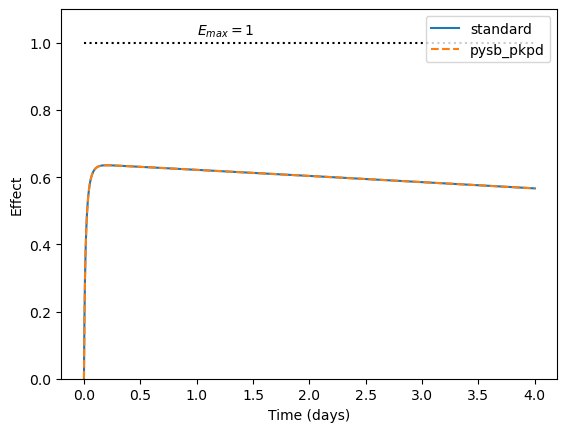

In [57]:
tspan_day = tspan / 86400
plt.hlines(1.0, 0, 4, linestyle=':', color='k')
plt.text(1, 1.025, "$E_{max}=1$")
plt.plot(tspan_day, out_standard['Emax_peripheral'], label='standard')
plt.plot(tspan_day, out_pkpd['Emax_expr_Drug_PERIPHERAL'], label='pysb_pkpd', linestyle='--')
plt.xlabel("Time (days)")
plt.ylabel("Effect")
plt.legend(loc=0)
plt.ylim((0, 1.1))

We can see that the two match, further verifying that the two models are equivalent.

------

### Case Study 2: Pembrolizumab semi-mechanistic PKRO model



This case study is adapted from the corresponding _Mechanistic PK/PD Example_ available at https://www.appliedbiomath.com/services/mechanistic-pkpd: _Inferring target occupancy from fitting nonlinear-PK data with mechanistic PKRO model for Pembrolizumab_.

In this adaptation, we will construct and simulate a PySB version of the semi-mechanistic pharmacokinetic and receptor occupancy (PKRO) model for the anti-PD-1 antibody drug Pembrolizumab (Pembro) they describe in their attached case study file. This model enables predictions of receptor occupancy under varying conditions. 

However, it's important to note that fitting the model to PK data (i.e., model calibration) is beyond the scope of this post and _will not_ be covered here. Instead, our focus will be on encoding the model and simulating it using a nominal set of parameters.

I've recreated the model schematic from the case study for reference:

![image](https://drive.google.com/uc?id=1Hc2a2IM_Sm1BaISVEqqHI5iiYgBidEWm)

**Some Notes:** The circles representing the different cell types are illustrative and do not represent separate compartments; the associated surface proteins are assumed to be distributed uniformly throughout the compartment (well-mixed approximation). All of the free cell surface proteins undergo zero-order synthesis and 1st-order degradation; when bound, PD-1 undergoes first-order degradation. Pembro in both the free and sPD-1-bound forms are cleared from the central compartment. Pembro binds both PD-1 and sPD-1 via reversible binding reactions in all compartments. PD-L1 binding to PD-1 only happens in the tumor compartment. 

### Constructing the Model

Alright, let's dive into encoding the model. We'll use a combination of standard PySB components and macros along with pysb-pkpd macros. 

We will use two standard PySB macros: _degrade_ and _bind_. We've already imported the _degrade_ macro, so let's import the _bind_ one here:

In [58]:
from pysb.macros import bind

Now we can initialize the new model, giving it a unique name:

In [59]:
Model(name='pembro')

<Model 'pembro' (monomers: 0, rules: 0, parameters: 0, expressions: 0, compartments: 0, energypatterns: 0) at 0x23fb3ff5810>

Next, we will add the model compartments. The model is a three-compartment model with _Central_, _Peripheral_, and _Tumor_ compartments. To add the compartments to the model we can use the pysb-pkpd macro `three_compartments`:

In [60]:
pkpd.three_compartments

<function pysb.pkpd.macros.three_compartments(c1_name='CENTRAL', c1_size=1.0, c2_name='PERIPHERAL', c2_size=1.0, c3_name='DEEPPERIPHERAL', c3_size=1.0)>

We just need to adjust the name of the third compartment from its default name `'DEEPPERIPHERAL'` to `'TUMOR'`:

In [61]:
pkpd.three_compartments(c3_name='TUMOR')

ComponentSet([
 Compartment(name='CENTRAL', parent=None, dimension=3, size=V_CENTRAL),
 Compartment(name='PERIPHERAL', parent=None, dimension=3, size=V_PERIPHERAL),
 Compartment(name='TUMOR', parent=None, dimension=3, size=V_TUMOR),
 Parameter('V_CENTRAL', 1.0),
 Parameter('V_PERIPHERAL', 1.0),
 Parameter('V_TUMOR', 1.0),
 ])

Now, we'll add the drug and other protein components to the model using PySB `Monomer`s:

  1. Pembro:

In [62]:
# The drug Pembrolizumab (Pembro) with one binding site.
Monomer("Pembro", ['b'])

Monomer('Pembro', ['b'])

  2. Membrane-bound PD1 receptor:

In [63]:
# PD1 with a single binding site:
Monomer("PD1", ['b'])

Monomer('PD1', ['b'])

  3. Soluble PD1 (sPD1):

In [64]:
# Soluble PD1 with one binding site:
Monomer("sPD1", ['b'])

Monomer('sPD1', ['b'])

  4. Tumor expressed PD-L1 protein:

In [65]:
Monomer("PDL1", ['b'])

Monomer('PDL1', ['b'])

Okay, now we can start adding all the PK processes and other mechanisms to the model. 

**Note on Units:**  we'll define amounts in $\textrm{n\,mols}$ (nanomoles), concentrations in $\textrm{nM}$,  first-order rate constants in $s^{-1}$, and second-order rate constants $(\textrm{nM} \times s)^{-1}$. 

We'll start with drug (Pembro) distribution between the different compartments:


  1. Central and Peripheral:

In [66]:
# Pembro distribution/re-distribution 
# between central and peripheral compartments.
pkpd.distribute(Pembro(b=None), CENTRAL, PERIPHERAL, [5e-5, 1e-3])  # 

ComponentSet([
 Rule('distribute_Pembro_CENTRAL_to_PERIPHERAL', Pembro(b=None) ** CENTRAL | Pembro(b=None) ** PERIPHERAL, distribute_Pembro_CENTRAL_to_PERIPHERAL_kf, distribute_Pembro_CENTRAL_to_PERIPHERAL_kr),
 Parameter('distribute_Pembro_CENTRAL_to_PERIPHERAL_kf', 5e-05),
 Parameter('distribute_Pembro_CENTRAL_to_PERIPHERAL_kr', 0.001),
 ])

  2. Central and Tumor:

In [67]:
# Pembro distribution/re-distribution 
# between central and tumor compartments.
pkpd.distribute(Pembro(b=None), CENTRAL, TUMOR, [2e-6, 6e-5])

ComponentSet([
 Rule('distribute_Pembro_CENTRAL_to_TUMOR', Pembro(b=None) ** CENTRAL | Pembro(b=None) ** TUMOR, distribute_Pembro_CENTRAL_to_TUMOR_kf, distribute_Pembro_CENTRAL_to_TUMOR_kr),
 Parameter('distribute_Pembro_CENTRAL_to_TUMOR_kf', 2e-06),
 Parameter('distribute_Pembro_CENTRAL_to_TUMOR_kr', 6e-05),
 ])

The drug undergoes elimination from the central compartment, which we'll go ahead and add:

In [68]:
# Drug elimination from the central compartment.
pkpd.eliminate(Pembro(b=WILD), CENTRAL, 3e-6) 

ComponentSet([
 Rule('eliminate_Pembro_CENTRAL', Pembro(b=WILD) ** CENTRAL >> None, eliminate_Pembro_CENTRAL_k),
 Parameter('eliminate_Pembro_CENTRAL_k', 3e-06),
 ])

Next, let's define all the binding interactions:

  1. Pembro and PD1:

In [69]:
# Binding interaction between Pembro and PD1 in all compartments,
# using the bind macro:
bind(Pembro, 'b', PD1, 'b', [5e-4, 8e-3])

ComponentSet([
 Rule('bind_Pembro_PD1', Pembro(b=None) + PD1(b=None) | Pembro(b=1) % PD1(b=1), bind_Pembro_PD1_kf, bind_Pembro_PD1_kr),
 Parameter('bind_Pembro_PD1_kf', 0.0005),
 Parameter('bind_Pembro_PD1_kr', 0.008),
 ])

  2. Pembro and soluble PD1:

In [70]:
# Binding interaction between Pembro and sPD1 in all compartments,
# using the bind macro:
bind(Pembro, 'b', sPD1, 'b', [5e-4, 8e-3])

ComponentSet([
 Rule('bind_Pembro_sPD1', Pembro(b=None) + sPD1(b=None) | Pembro(b=1) % sPD1(b=1), bind_Pembro_sPD1_kf, bind_Pembro_sPD1_kr),
 Parameter('bind_Pembro_sPD1_kf', 0.0005),
 Parameter('bind_Pembro_sPD1_kr', 0.008),
 ])

  3. PD1 and PD-L1 in the Tumor:

In [71]:
# Binding interaction between Pembro and PDL1 in the tumor compartment,
# using the bind macro:
bind(PD1(b=None)**TUMOR, 'b', PDL1(b=None)**TUMOR, 'b', [1e-7, 1e-2])

ComponentSet([
 Rule('bind_PD1_PDL1', PD1(b=None) ** TUMOR + PDL1(b=None) ** TUMOR | PD1(b=1) ** TUMOR % PDL1(b=1) ** TUMOR, bind_PD1_PDL1_kf, bind_PD1_PDL1_kr),
 Parameter('bind_PD1_PDL1_kf', 1e-07),
 Parameter('bind_PD1_PDL1_kr', 0.01),
 ])

The model also includes PD1 turnover, which includes:

  1. Synthesis of PD1 in all compartments:

In [72]:
# We'll use this complex pattern to apply synthesis of 
# PD1 in all three compartments.
pd1_all = (PD1(b=None)**CENTRAL + PD1(b=None)**PERIPHERAL + PD1(b=None)**TUMOR)

In [73]:
# Zero-order rate constant and Rule for the synthesis:
Parameter("k_PD1_synth", 3e-6)
Rule("PD1_synth", None >> pd1_all, k_PD1_synth)

Rule('PD1_synth', None >> PD1(b=None) ** CENTRAL + PD1(b=None) ** PERIPHERAL + PD1(b=None) ** TUMOR, k_PD1_synth)

  2. Degradation of PD1 in all binding states and all compartments:

In [74]:
# Using the degrade macro here:
degrade(PD1(b=WILD), 3e-6)

ComponentSet([
 Rule('degrade_PD1WILD', PD1(b=WILD) >> None, degrade_PD1WILD_k),
 Parameter('degrade_PD1WILD_k', 3e-06),
 ])

Next, we can set up the drug dose and initial conditions for all the other proteins:

  1. Drug dose of Pembro which is added to the central compartment by first-order absorption:

<div class="alert alert-info">
A drug dose with first-order absorption can added to the model with the pysb-pkpd <strong>dose_absorbed</strong> macro.
</div>

In [75]:
pkpd.dose_absorbed

<function pysb.pkpd.macros.dose_absorbed(species, compartment, dose, ka, f)>

In [76]:
# We'll use the pysb-pkpd dose_absorbed macro. The parameter
# f is the bioavailability fraction.
pkpd.dose_absorbed(Pembro(b=None), CENTRAL, 2000.0, 3e-3, 1.0)

ComponentSet([
 Rule('absorb_Pembro_CENTRAL', Pembro_CENTRAL_precursor() ** CENTRAL >> Pembro(b=None) ** CENTRAL, absorb_Pembro_CENTRAL_ka),
 Parameter('absorb_Pembro_CENTRAL_ka', 0.003),
 Parameter('dose_Pembro_CENTRAL', 2000.0),
 Expression('expr_Pembro_CENTRAL_dose', dose_Pembro_CENTRAL/V_CENTRAL),
 Parameter('ka_Pembro_CENTRAL', 0.003),
 Parameter('F_Pembro_CENTRAL', 1.0),
 Monomer('Pembro_CENTRAL_precursor'),
 ])

  2. PD1 in each compartment:

In [77]:
Parameter('PD1_CP0', 0.0141)
Initial(PD1(b=None)**CENTRAL, PD1_CP0)
Initial(PD1(b=None)**PERIPHERAL, PD1_CP0)
Parameter('PD1_T0', 0.083)
Initial(PD1(b=None)**TUMOR, PD1_T0)

Initial(PD1(b=None) ** TUMOR, PD1_T0)

  3. Soluble PD1 (sPD1) in each compartment:

In [78]:
Parameter('sPD1_0', 0.0143)
Initial(sPD1(b=None)**CENTRAL, sPD1_0)
Initial(sPD1(b=None)**PERIPHERAL, sPD1_0)
Initial(sPD1(b=None)**TUMOR, sPD1_0)

Initial(sPD1(b=None) ** TUMOR, sPD1_0)

  4. PD-L1 protein expressed in the tumor compartment:

In [79]:
Parameter('PDL1_0', 0.010)
Initial(PDL1(b=None)**TUMOR, PDL1_0)

Initial(PDL1(b=None) ** TUMOR, PDL1_0)

Finally, we'll define all the observable quantities we want to monitor:

  1. Pembro RO at PD1 in the tumor:

In [80]:
# Pembro bound to PD1 in the tumor:
Observable("Pembro_PD1_TUMOR", Pembro(b=ANY)**TUMOR % PD1(b=ANY)**TUMOR)

Observable('Pembro_PD1_TUMOR', Pembro(b=ANY) ** TUMOR % PD1(b=ANY) ** TUMOR)

In [81]:
# Total PD1 in the tumor:
Observable("PD1_TUMOR", PD1(b=WILD)**TUMOR)

Observable('PD1_TUMOR', PD1(b=WILD) ** TUMOR)

In [82]:
# The percentage RO for Pembro at PD1:
Expression("RO_TUMOR", 100 * Pembro_PD1_TUMOR / PD1_TUMOR) 

Expression('RO_TUMOR', 100*Pembro_PD1_TUMOR/PD1_TUMOR)

  2. Pembro in each compartment:

In [83]:
# Total Pembro in the central compartment:
Observable("Pembro_CENTRAL", Pembro(b=WILD)**CENTRAL)

Observable('Pembro_CENTRAL', Pembro(b=WILD) ** CENTRAL)

In [84]:
# Total Pembro in the tumor compartment:
Observable("Pembro_TUMOR", Pembro(b=WILD)**TUMOR)

Observable('Pembro_TUMOR', Pembro(b=WILD) ** TUMOR)

In [85]:
# Total Pembro in the peripheral compartment:
Observable("Pembro_PERIPHERAL", Pembro(b=WILD)**PERIPHERAL)

Observable('Pembro_PERIPHERAL', Pembro(b=WILD) ** PERIPHERAL)

  3. Total circulating Pembro in the plasma (i.e., central compartment), which is assumed to include both free Pembro and Pembro bound to soluble PD1:

In [86]:
# Free, unbound, Pembro in the central compartment:
Observable("Pembro_free_CENTRAL", Pembro(b=None)**CENTRAL)

Observable('Pembro_free_CENTRAL', Pembro(b=None) ** CENTRAL)

In [87]:
# Pembro bound to soluble PD1 in the central compartent:
Observable("Pembro_sPD1_CENTRAL", Pembro(b=ANY)**CENTRAL % sPD1(b=ANY)**CENTRAL)

Observable('Pembro_sPD1_CENTRAL', Pembro(b=ANY) ** CENTRAL % sPD1(b=ANY) ** CENTRAL)

In [88]:
# Total circulating Pembro:
Expression("Pembro_plasma", Pembro_free_CENTRAL + Pembro_sPD1_CENTRAL)

Expression('Pembro_plasma', Pembro_free_CENTRAL + Pembro_sPD1_CENTRAL)

We can look at the model summary:

In [89]:
print(pembro)

<Model 'pembro' (monomers: 5, rules: 9, parameters: 24, expressions: 4, compartments: 3, energypatterns: 0) at 0x23fb3ff5810>


A condensed version of the model code looks like:

```python
from pysb import *
from pysb.macros import bind, degrade
import pysb.pkpd as pkpd

Model(name='pembro')

pkpd.three_compartments(c3_name='TUMOR')

# The drug Pembrolizumab (Pembro) with one binding site.
Monomer("Pembro", ['b'])
# PD1 with a single binding site:
Monomer("PD1", ['b'])
# Soluble PD1 with one binding site:
Monomer("sPD1", ['b'])
# PD-L1 protein with one binding site:
Monomer("PDL1", ['b'])

# Pembro distribution/re-distribution 
# between central and peripheral compartments.
pkpd.distribute(Pembro(b=None), CENTRAL, PERIPHERAL, [5e-6, 1e-4])
# Pembro distribution/re-distribution 
# between central and tumor compartments.
pkpd.distribute(Pembro(b=None), CENTRAL, TUMOR, [2e-6, 6e-5])

# Drug elimination from the central compartment.
pkpd.eliminate(Pembro(b=WILD), CENTRAL, 6e-6) 

bind(Pembro, 'b', PD1, 'b', [5e-4, 8e-3])
bind(Pembro, 'b', sPD1, 'b', [5e-4, 8e-3])
bind(PD1(b=None)**TUMOR, 'b', PDL1(b=None)**TUMOR, 'b', [1e-7, 1e-2])

degrade(PD1(b=WILD), 3e-6)
pd1_all = (PD1(b=None)**CENTRAL + PD1(b=None)**PERIPHERAL + PD1(b=None)**TUMOR)

Parameter("k_PD1_synth", 3e-6)
Rule("PD1_synth", None >> pd1_all, k_PD1_synth)

pkpd.dose_absorbed(Pembro(b=None), CENTRAL, 2000.0, 3e-3, 1.0)

Parameter('PD1_CP0', 0.1)
Initial(PD1(b=None)**CENTRAL, PD1_CP0)
Initial(PD1(b=None)**PERIPHERAL, PD1_CP0)
Parameter('PD1_T0', 0.083)
Initial(PD1(b=None)**TUMOR, PD1_T0)

Parameter('sPD1_0', 0.0415)
Initial(sPD1(b=None)**CENTRAL, sPD1_0)
Initial(sPD1(b=None)**PERIPHERAL, sPD1_0)
Initial(sPD1(b=None)**TUMOR, sPD1_0)

Parameter('PDL1_0', 0.010)
Initial(PDL1(b=None)**TUMOR, PDL1_0)

Observable("Pembro_PD1_TUMOR", Pembro(b=ANY)**TUMOR % PD1(b=ANY)**TUMOR)
Observable("PD1_TUMOR", PD1(b=WILD)**TUMOR)
Expression("RO_TUMOR", 100 * Pembro_PD1_TUMOR / PD1_TUMOR) 
Observable("Pembro_CENTRAL", Pembro(b=WILD)**CENTRAL)
Observable("Pembro_TUMOR", Pembro(b=WILD)**TUMOR)
Observable("Pembro_PERIPHERAL", Pembro(b=WILD)**PERIPHERAL)
```

#### Simulate the model

Now, let's try simulating the model.

  1. Initialize the simulator with our new model:

In [90]:
sim = ScipyOdeSimulator(pembro)

  2. Define the time course we want to simulate:

In [91]:
# 86,400 s/day
# 8 days with timepoints every 10 seconds:
tspan = np.arange(0, 86400 * 8, 10)
tspan

array([     0,     10,     20, ..., 691170, 691180, 691190])

  3. Run the simulation and extract the outputs:

In [92]:
out = sim.run(tspan=tspan).all

#### Visualize Results

Here,we can plot the key outputs, including:

  1. Total Pembro in each model compartment:

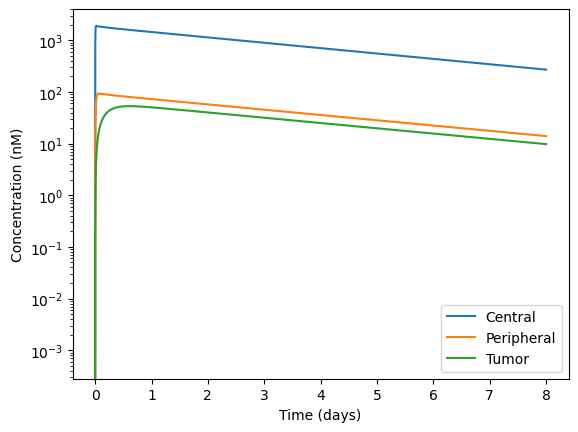

In [93]:
tspan_day = tspan / 86400
plt.plot(tspan_day, out['Pembro_CENTRAL'], label='Central')
plt.plot(tspan_day, out['Pembro_PERIPHERAL'], label='Peripheral')
plt.plot(tspan_day, out['Pembro_TUMOR'], label='Tumor')
plt.xlabel("Time (days)")
plt.ylabel("Concentration (nM)")
plt.legend(loc=0)
plt.yscale('log')

  2. Total circulating Pembro:

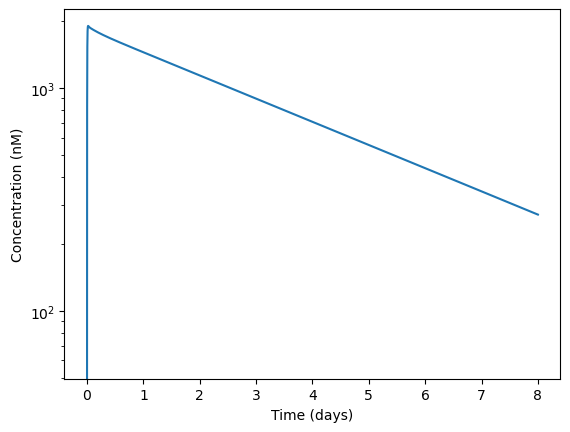

In [94]:
plt.plot(tspan_day, out['Pembro_plasma'])
plt.xlabel("Time (days)")
plt.ylabel("Concentration (nM)")
#plt.legend(loc=0)
plt.yscale('log')

  3. RO for Pembro at PD1 in the tumor:

Text(0, 0.5, 'RO (%)')

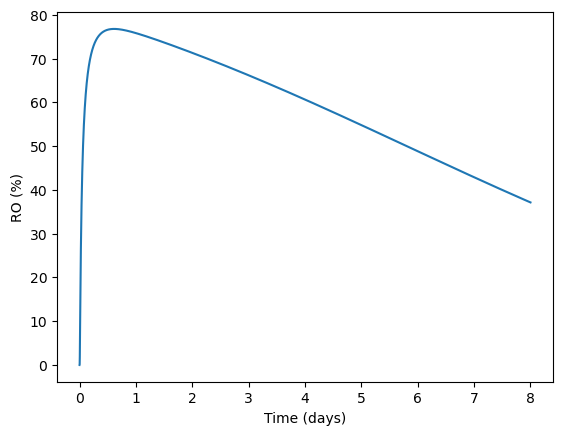

In [95]:
plt.plot(tspan_day, out['RO_TUMOR'])
plt.xlabel("Time (days)")
plt.ylabel("RO (%)")

## Closing Thoughts

In this post, we covered the basics of PK/PD modeling and did a quick overview of the PySB modeling framework. Then, we dove into creating and simulating dynamic PK/PD models of drug behavior and response using PySB and pysb-pkpd by working through two illustrative case studies. With these case studies, we demonstrated the power of combining PySB with the pysb-pkpd add-on to programmatically construct and execute different types of PK/PD models, such as compartmental models, mechanistic/semi-mechanistic models, and quantitative systems pharmacology/toxicology models.

Whether you're an aspiring PK/PD modeler, a Python enthusiast, or simply curious about pharmacology, I hope you've found this post helpful and informative. 

Now, it's your turn. Go out and experiment more with PySB and pysb-pkpd, construct your own models, or explore other real-world PK/PD modeling applications. And, if you know someone else who might find this post useful, please share! 

Well, that’s it. Thanks for stopping by! If you have questions or comments, feel free to [email me](mailto:blakeaw1102@gmail.com) or hit me up on [LinkedIn](https://www.linkedin.com/in/blakewilson3/).

Until next time – Blake

Like this content? You can follow this blog and get updated about new posts via my blog's RSS/Atom Feed. 

## Acknowledgements

I'd like to thank Dr. Oscar Ortega, whose remarks ultimately influenced my decision to further explore PySB as a framework for PK/PD modeling.

I used ChatGPT to help construct an initial outline of this post, and I used Grammarly and ChatGPT for proofreading and editing.

## References

1. <div class="csl-entry">Meibohm, B., &#38; Derendorf, H. (1997). Basic concepts of pharmacokinetic/pharmacodynamic (PK/PD) modeling. <i>International Journal of Clinical Pharmacology and Therapeutics</i>, <i>35</i>(10), 401–413.</div>

2. <div class="csl-entry">Zou, H., Banerjee, P., Leung, S. S. Y., &#38; Yan, X. (2020). Application of Pharmacokinetic-Pharmacodynamic Modeling in Drug Delivery: Development and Challenges. <i>Frontiers in Pharmacology</i>, <i>11</i>, 543082. https://doi.org/10.3389/FPHAR.2020.00997/BIBTEX</div>

3. <div class="csl-entry"><i>What Is a Pharmacokinetic Model?</i> (n.d.). Retrieved October 11, 2023, from https://www.mathworks.com/discovery/pharmacokinetic.html</div>

4. <div class="csl-entry"><i>Compartmental Modeling in Pharmacokinetics | Allucent</i>. (n.d.). Retrieved October 10, 2023, from https://www.allucent.com/resources/blog/compartmental-modeling-pharmacokinetics</div>

5. <div class="csl-entry">Doogue, M. P., &#38; Polasek, T. M. (2013). The ABCD of clinical pharmacokinetics. <i>Therapeutic Advances in Drug Safety</i>, <i>4</i>(1), 5–7. https://doi.org/10.1177/2042098612469335/ASSET/IMAGES/LARGE/10.1177_2042098612469335-FIG1.JPEG</div>

6. <div class="csl-entry"><i>PK and PD Modeling - Open Systems Pharmacology</i>. (n.d.). Retrieved October 11, 2023, from https://docs.open-systems-pharmacology.org/mechanistic-modeling-of-pharmacokinetics-and-dynamics/modeling-concepts/modeling-concepts-pk-and-pd-modeling</div>

7. <div class="csl-entry">Teuscher, N. (2011). <i>What are Compartmental Models? | Certara</i>. https://www.certara.com/knowledge-base/what-are-compartmental-models/</div>

8. <div class="csl-entry">Ki, S. (2020). A semi-compartmental model describing the pharmacokinetic-pharmacodynamic relationship. <i>Anesthesia and Pain Medicine</i>, <i>15</i>(1), 1–7. https://doi.org/10.17085/APM.2020.15.1.1</div>

9. <div class="csl-entry"><i>Single and multiple compartment models of drug distribution | Deranged Physiology</i>. (n.d.). Retrieved October 11, 2023, from https://derangedphysiology.com/main/cicm-primary-exam/required-reading/pharmacokinetics/Chapter%20201/single-and-multiple-compartment-models-drug-distribution</div>

10. <div class="csl-entry"><i>Mechanistic PK/PD | Applied BioMath</i>. (n.d.). Retrieved October 11, 2023, from https://www.appliedbiomath.com/services/mechanistic-pkpd</div>

11. <div class="csl-entry">Grant, J., Hua, F., Apgar, J. F., Burke, J. M., &#38; Marcantonio, D. H. (2023). Mechanistic PK/PD modeling to address early-stage biotherapeutic dosing feasibility questions. <i>MAbs</i>, <i>15</i>(1). https://doi.org/10.1080/19420862.2023.2192251</div>

12. <div class="csl-entry">Sorger, P. K., Allerheiligen, S. R. B., Abernethy, D. R., Altman, R. B., Brouwer, K. L. R., Califano, A., D’argenio, D. Z., Iyengar, R., Jusko, W. J., Lalonde, R., Lauffenburger, D. A., Shoichet, B., Stevens, J. L., Subramaniam, S., van der Graaf, P., Vicini, P., Lalonde, R. L., &#38; Ward, R. (n.d.). <i>Quantitative and Systems Pharmacology in the Post-genomic Era: New Approaches to Discovering Drugs and Understanding Therapeutic Mechanisms Author Affiliations</i>.</div>

13. <div class="csl-entry"><i>Quantitative Systems Pharmacology | Applied BioMath</i>. (n.d.). Retrieved October 11, 2023, from https://www.appliedbiomath.com/services/quantitative-systems-pharmacology</div>

14. <div class="csl-entry">Bloomingdale, P., Housand, C., Apgar, J. F., Millard, B. L., Mager, D. E., Burke, J. M., &#38; Shah, D. K. (2017). Quantitative systems toxicology. <i>Current Opinion in Toxicology</i>, <i>4</i>, 79–87. https://doi.org/10.1016/J.COTOX.2017.07.003</div>

15. <div class="csl-entry">Stark, J. (n.d.). <i>Two Compartment Body Model and V d Terms</i>. Retrieved October 11, 2023, from https://pharmacy.ufl.edu/files/2013/01/two-compartment-model.pdf</div>

16. <div class="csl-entry">Jones, H. M., &#38; Rowland-Yeo, K. (2013). Basic Concepts in Physiologically Based Pharmacokinetic Modeling in Drug Discovery and Development. <i>CPT: Pharmacometrics &#38; Systems Pharmacology</i>, <i>2</i>(8), e63. https://doi.org/10.1038/PSP.2013.41</div>

17. <div class="csl-entry"><i>PHYSIOLOGICALLY-BASED PHARMACOKINETIC (PBPK) MODELS</i>. (2018). https://www.epa.gov/sites/default/files/2018-02/documents/pbpk_factsheet_feb2018_0.pdf</div>

18. <div class="csl-entry">Sharma P, Dunham A. Pharmacy Calculations. [Updated 2023 Jun 20]. In: StatPearls [Internet]. Treasure Island (FL): StatPearls Publishing; 2023 Jan-. Available from: https://www.ncbi.nlm.nih.gov/books/NBK560924/</div>

19. <div class="csl-entry">Barbour, A. M., &#38; Fossler, M. J. (2018). Infusions Are the Optimal Dosing Method in Intravenous ADME Studies Rather Than Bolus Dosing. In <i>Journal of Clinical Pharmacology</i> (Vol. 58, Issue 1, pp. 25–28). Blackwell Publishing Inc. https://doi.org/10.1002/jcph.991</div>

20. <div class="csl-entry">Price G, Patel DA. Drug Bioavailability. [Updated 2023 Jul 30]. In: StatPearls [Internet]. Treasure Island (FL): StatPearls Publishing; 2023 Jan-. Available from: https://www.ncbi.nlm.nih.gov/books/NBK557852/</div>

21. <div class="csl-entry">Mansoor A, Mahabadi N. Volume of Distribution. [Updated 2023 Jul 24]. In: StatPearls [Internet]. Treasure Island (FL): StatPearls Publishing; 2023 Jan-. Available from: https://www.ncbi.nlm.nih.gov/books/NBK545280/</div>

22. <div class="csl-entry"><i>Volume of distribution | Deranged Physiology</i>. (n.d.). Retrieved October 16, 2023, from https://derangedphysiology.com/main/cicm-primary-exam/required-reading/pharmacokinetics/Chapter%20202/volume-distribution</div>

23. <div class="csl-entry"> Garza AZ, Park SB, Kocz R. Drug Elimination. [Updated 2023 Jul 4]. In: StatPearls [Internet]. Treasure Island (FL): StatPearls Publishing; 2023 Jan-. Available from: https://www.ncbi.nlm.nih.gov/books/NBK547662/</div>

24. <div class="csl-entry">Holford, N., &#38; Yim, D.-S. (2015). Clearance. <i>Transl Clin Pharmacol</i>, <i>23</i>(2), 48–1992. https://doi.org/10.12793/tcp.2015.23.2.42</div>

25. <div class="csl-entry"> Horde GW, Gupta V. Drug Clearance. [Updated 2023 Jun 20]. In: StatPearls [Internet]. Treasure Island (FL): StatPearls Publishing; 2023 Jan-. Available from: https://www.ncbi.nlm.nih.gov/books/NBK557758/</div>

26. <div class="csl-entry">Felmlee, M. A., Morris, M. E., &#38; Mager, D. E. (2012). Mechanism-Based Pharmacodynamic Modeling. <i>Methods in Molecular Biology (Clifton, N.J.)</i>, <i>929</i>, 583. https://doi.org/10.1007/978-1-62703-050-2_21</div>

27. <div class="csl-entry">Lopez, C. F., Muhlich, J. L., Bachman, J. A., &#38; Sorger, P. K. (2013). Programming biological models in Python using PySB. <i>Molecular Systems Biology</i>, <i>9</i>(1), 646. https://doi.org/10.1038/MSB.2013.1</div>

28. <div class="csl-entry">Hogg, J. S., Harris, L. A., Stover, L. J., Nair, N. S., &#38; Faeder, J. R. (2014). Exact Hybrid Particle/Population Simulation of Rule-Based Models of Biochemical Systems. <i>PLOS Computational Biology</i>, <i>10</i>(4), e1003544. https://doi.org/10.1371/JOURNAL.PCBI.1003544</div>